In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import LfuncN, LfuncAr, LfuncNe
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
import os
import pickle as pkl
from LRBv2 import LRBv2
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from DLScommonTools import *

%load_ext autoreload
%autoreload 2

fontsize = 12

plt.rc('font', size=fontsize) #controls default text size
plt.rc('axes', titlesize=fontsize) #fontsize of the title
plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize) #fontsize of the y tick labels
plt.rc('legend', fontsize=fontsize) #fontsize of the legend



In [2]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"

list_sides = ["iu", "ou"]
data = dict()
sepadd = 2
res = 500

for side in list_sides:
    data[side] = unpackConfigurationMK(
        File = gridFile, Type = side, sepadd = 2, resolution = res, convention = "target_to_midplane")

In [3]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": False, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.05,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


# Outer

In [64]:
scan2d = list()
list_BxBt_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])
list_Lc_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])

side = "ou"

for i, BxBt_scale in enumerate(list_BxBt_scales):
    print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
    out = []
    results = dict()
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []
    
    for j, Lc_scale in enumerate(list_Lc_scales):
        print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")
        
        d = data[side].copy()
        
        d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
        d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)

        constants = constants_default.copy()
        radios = radios_default.copy()
        indexRange = np.linspace(0, d["Xpoint"], 2).astype(int)
        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

        out.append(LRBv2(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                            control_variable = "impurity_frac"))
        
        # Work on current set of results
        out[j]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]
        results["window"].append(out[j]["cvar"][-1] - out[j]["cvar"][0])
        results["window_ratio"].append(out[j]["cvar"][-1] / out[j]["cvar"][0])
        results["threshold"].append(out[j]["cvar"][0])
        results["indexRange"] = indexRange
        results["constants"] = constants
        results["radios"] = radios
        
        # Take out any thresholds for a window ratio < 1
        for k, x in enumerate(results["threshold"]):
            if results["window_ratio"][k] < 1:
                results["threshold"][k] = np.nan

        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])

    results["out"] = out
    
    scan2d.append(results)


Running BxBt scale factor: 0.50 -- Running Lc scale factor: 0.50 -- Solving...0...183...Complete in 0.9 seconds
Running Lc scale factor: 0.62 -- Solving...0...183...Complete in 1.1 seconds
Running Lc scale factor: 0.75 -- Solving...0...183...Complete in 1.0 seconds
Running Lc scale factor: 0.88 -- Solving...0...183...Complete in 1.1 seconds
Running Lc scale factor: 1.00 -- Solving...0...183...Complete in 0.8 seconds
Running Lc scale factor: 1.25 -- Solving...0...183...Complete in 0.9 seconds
Running Lc scale factor: 1.50 -- Solving...0...183...Complete in 0.9 seconds
Running Lc scale factor: 1.75 -- Solving...0...183...Complete in 1.3 seconds
Running Lc scale factor: 2.00 -- Solving...0...183...Complete in 1.3 seconds
Running BxBt scale factor: 0.62 -- Running Lc scale factor: 0.50 -- Solving...0...183...Complete in 1.1 seconds
Running Lc scale factor: 0.62 -- Solving...0...183...Complete in 1.3 seconds
Running Lc scale factor: 0.75 -- Solving...0...183...Complete in 1.1 seconds
Runnin

In [289]:
arr_outer_cz = make_arrays(scan2d, list_BxBt_scales, list_Lc_scales)

IndexError: list index out of range

Text(0.5, 1.0, 'Outer divertor impurity window')

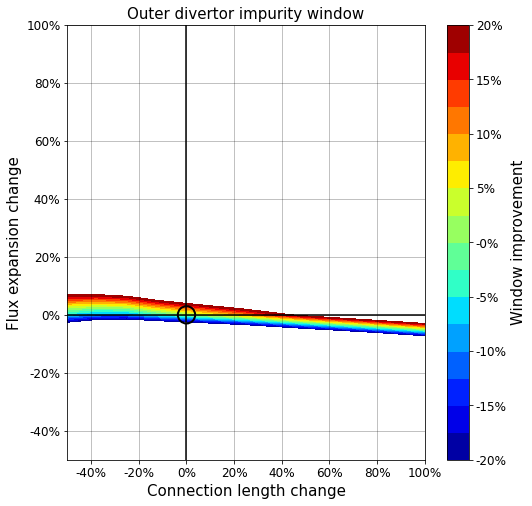

In [287]:
fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

levels = np.arange(-0.2, 0.225, 0.025)
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr_outer_cz["window_norm"], levels = levels, cmap = cmap, vmin = -0.2)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Window improvement", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black")
ax.vlines(0, -0.5, 1, color = "black")

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor impurity window", fontsize = 15)

Text(0.5, 1.0, 'Outer divertor impurity threshold')

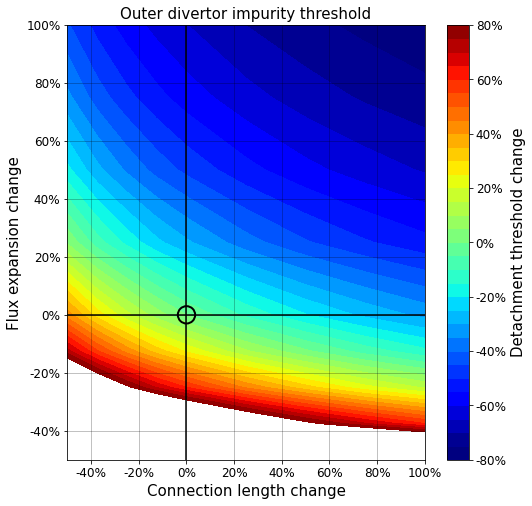

In [218]:
fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

levels = np.arange(-0.75-0.05, 0.75+0.075, 0.05)

cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr_threshold_norm, levels = levels, cmap = cmap, vmin = -0.75)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Detachment threshold change", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black")
ax.vlines(0, -0.5, 1, color = "black")

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor impurity threshold", fontsize = 15)

# Inner

In [223]:
scan2d_iu = list()
list_BxBt_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])
list_Lc_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])

side = "iu"

for i, BxBt_scale in enumerate(list_BxBt_scales):
    print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
    out = []
    results = dict()
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []
    
    for j, Lc_scale in enumerate(list_Lc_scales):
        print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")
        
        d = data[side].copy()
        
        d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
        d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)

        constants = constants_default.copy()
        radios = radios_default.copy()
        indexRange = np.linspace(0, d["Xpoint"], 2).astype(int)
        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

        out.append(LRBv2(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                            control_variable = "impurity_frac"))
        
        # Work on current set of results
        out[j]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]
        results["window"].append(out[j]["cvar"][-1] - out[j]["cvar"][0])
        results["window_ratio"].append(out[j]["cvar"][-1] / out[j]["cvar"][0])
        results["threshold"].append(out[j]["cvar"][0])
        results["indexRange"] = indexRange
        results["constants"] = constants
        results["radios"] = radios
        
        # Take out any thresholds for a window ratio < 1
        for k, x in enumerate(results["threshold"]):
            if results["window_ratio"][k] < 1:
                results["threshold"][k] = np.nan
        try:
            results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
        except:
            pass
    results["out"] = out
    
    scan2d_iu.append(results)


Running BxBt scale factor: 0.50 -- Running Lc scale factor: 0.50 -- Solving...0...55...Complete in 1.2 seconds
Running Lc scale factor: 0.62 -- Solving...0...55...Complete in 1.2 seconds
Running Lc scale factor: 0.75 -- Solving...0...55...Complete in 1.1 seconds
Running Lc scale factor: 0.88 -- Solving...0...55...Complete in 1.3 seconds
Running Lc scale factor: 1.00 -- Solving...0...55...Complete in 1.4 seconds
Running Lc scale factor: 1.25 -- Solving...0...55...Complete in 1.6 seconds
Running Lc scale factor: 1.50 -- Solving...0...55...Complete in 1.3 seconds
Running Lc scale factor: 1.75 -- Solving...0...55...Complete in 0.8 seconds
Running Lc scale factor: 2.00 -- Solving...0...55...Complete in 1.7 seconds
Running BxBt scale factor: 0.62 -- Running Lc scale factor: 0.50 -- Solving...0...55...Complete in 1.2 seconds
Running Lc scale factor: 0.62 -- Solving...0...55...Complete in 1.1 seconds
Running Lc scale factor: 0.75 -- Solving...0...55...Complete in 1.1 seconds
Running Lc scale f

Text(0.5, 1.0, 'Outer divertor impurity window')

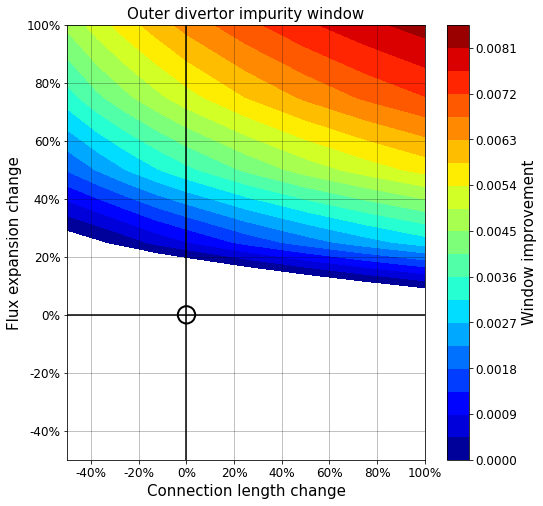

In [280]:
arr_inner_cz = make_arrays(scan2d_iu, list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

levels = np.linspace(0, 0.0085,20)
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr_inner_cz["window"], levels = levels, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Window improvement", size = 15)
cb.ax.set_yticklabels(["{:.4f}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor impurity window", fontsize = 15)

# Outer and inner, density

In [4]:
scan2d_ne = dict()
list_BxBt_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])
list_Lc_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])


for side in ["iu", "ou"]:
    scan2d_ne[side] = list()
    
    for i, BxBt_scale in enumerate(list_BxBt_scales):
        print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
        out = []
        results = dict()
        for param in ["window", "threshold", "window_ratio"]:
            results[param] = []

        for j, Lc_scale in enumerate(list_Lc_scales):
            print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")

            d = data[side].copy()

            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)

            constants = constants_default.copy()
            radios = radios_default.copy()
            indexRange = np.linspace(0, d["Xpoint"], 2).astype(int)
            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            constants["cz0"] = 0.02
            out.append(LRBv2(constants,radios,d["S"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                                control_variable = "density"))

            # Work on current set of results
            out[j]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]
            results["window"].append(out[j]["cvar"][-1] - out[j]["cvar"][0])
            results["window_ratio"].append(out[j]["cvar"][-1] / out[j]["cvar"][0])
            results["threshold"].append(out[j]["cvar"][0])
            results["indexRange"] = indexRange
            results["constants"] = constants
            results["radios"] = radios

            # Take out any thresholds for a window ratio < 1
            for k, x in enumerate(results["threshold"]):
                if results["window_ratio"][k] < 1:
                    results["threshold"][k] = np.nan
            try:
                results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
            except:
                pass

        results["out"] = out

        scan2d_ne[side].append(results)


Running BxBt scale factor: 0.50 -- Running Lc scale factor: 0.50 -- Solving...0...55...Complete in 2.4 seconds
Running Lc scale factor: 0.62 -- Solving...0...55...Complete in 2.5 seconds
Running Lc scale factor: 0.75 -- Solving...0...55...Complete in 2.4 seconds
Running Lc scale factor: 0.88 -- Solving...0...55...Complete in 2.3 seconds
Running Lc scale factor: 1.00 -- Solving...0...55...Complete in 3.2 seconds
Running Lc scale factor: 1.25 -- Solving...0...55...Complete in 2.6 seconds
Running Lc scale factor: 1.50 -- Solving...0...55...Complete in 2.2 seconds
Running Lc scale factor: 1.75 -- Solving...0...55...Complete in 2.7 seconds
Running Lc scale factor: 2.00 -- Solving...0...55...Complete in 2.8 seconds
Running BxBt scale factor: 0.62 -- Running Lc scale factor: 0.50 -- Solving...0...55...Complete in 2.7 seconds
Running Lc scale factor: 0.62 -- Solving...0...55...Complete in 2.1 seconds
Running Lc scale factor: 0.75 -- Solving...0...55...Complete in 2.0 seconds
Running Lc scale f

In [19]:
def make_arrays(scan2d, list_BxBt_scales, list_Lc_scales):
# Calculate 2D arrays of detachment window and threshold improvement
    arr_window = []
    arr_threshold = []
    arr_window_ratio = []
    arr = dict()

    for i, BxBt_scale in enumerate(list_BxBt_scales):
        arr_window.append(scan2d[i]["window"])
        arr_threshold.append(scan2d[i]["threshold"])
        arr_window_ratio.append(scan2d[i]["window_ratio"])

    arr["window"] = np.array(arr_window) 
    arr["threshold"] = np.array(arr_threshold)
    arr["window_ratio"] = np.array(arr_window_ratio)

    index_1_BxBt = np.where(list_BxBt_scales == 1)
    index_1_Lc = np.where(list_Lc_scales == 1)
    window_norm = arr["window"][index_1_BxBt,index_1_Lc]
    threshold_norm = arr["threshold"][index_1_BxBt,index_1_Lc]

    arr["window_norm"] = (arr["window"] - window_norm) / abs(window_norm)
    arr["threshold_norm"] = arr["threshold"] / threshold_norm
    arr["threshold_norm"] -= 1

    return arr

arr_ne = dict()
arr_ne["iu"] = make_arrays(scan2d_ne["iu"], list_BxBt_scales, list_Lc_scales)

## Inner

### Absolute

Text(0.5, 1.0, 'Inner divertor density window')

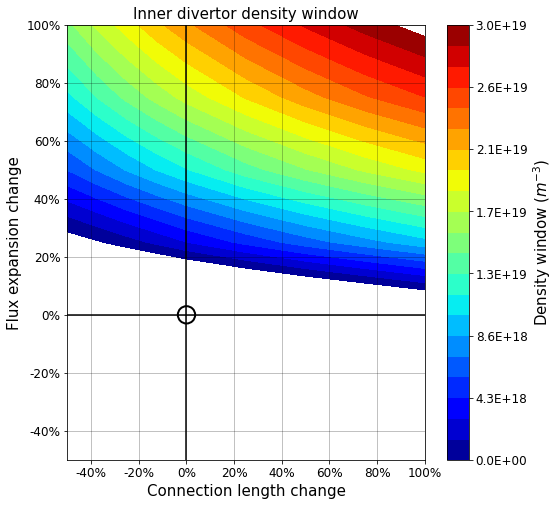

In [23]:
arr = make_arrays(scan2d_ne["iu"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

levels = np.linspace(0, 3.0e19,22)
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["window"], levels = levels, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Density window ($m^{-3}$)", size = 15)
cb.ax.set_yticklabels(["{:.1E}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Inner divertor density window", fontsize = 15)

### Relative window

Text(0.5, 1.0, 'Inner divertor density window')

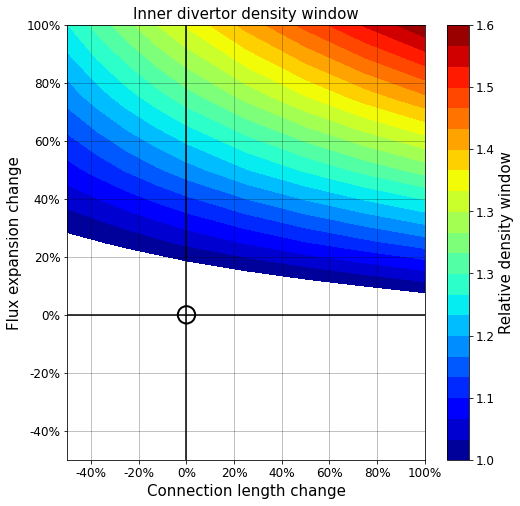

In [33]:
arr = make_arrays(scan2d_ne["iu"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

levels = np.linspace(1, 1.6 ,22)
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["window_ratio"], levels = levels, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Relative density window", size = 15)
cb.ax.set_yticklabels(["{:.1f}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Inner divertor density window", fontsize = 15)

## Outer

### Absolute

Text(0.5, 1.0, 'Outer divertor density window')

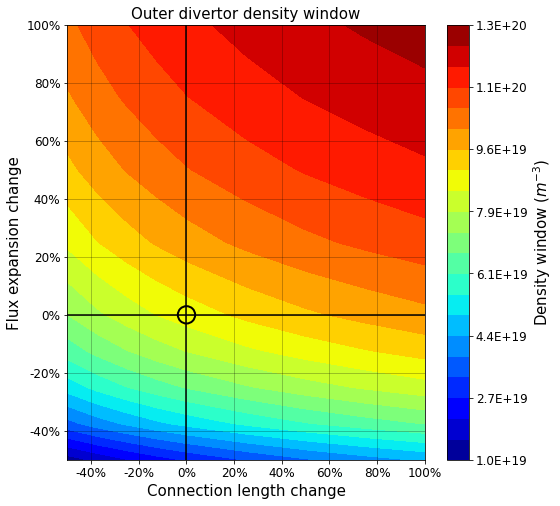

In [40]:
arr = make_arrays(scan2d_ne["ou"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

levels = np.linspace(1e19, 1.3e20,22)
# levels = np.arange(-0.5, 0.55, 0.05)

cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["window"], levels = levels, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Density window ($m^{-3}$)", size = 15)
cb.ax.set_yticklabels(["{:.1E}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor density window", fontsize = 15)

### Relative

Text(0.5, 1.0, 'Outer divertor density window')

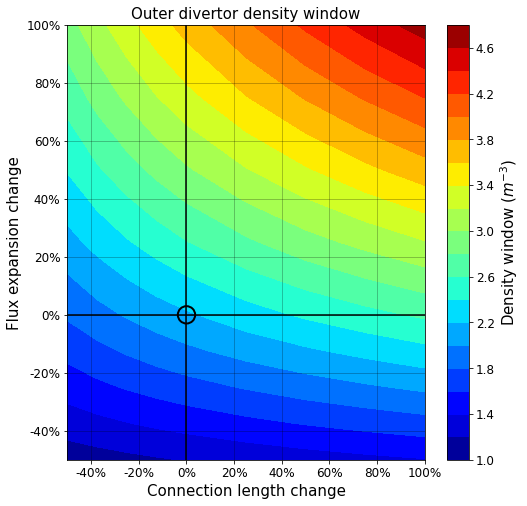

In [41]:
arr = make_arrays(scan2d_ne["ou"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["window_ratio"], levels = 22, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Density window ($m^{-3}$)", size = 15)
cb.ax.set_yticklabels(["{:.1f}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor density window", fontsize = 15)

### Percent change

Text(0.5, 1.0, 'Outer divertor density window improvement')

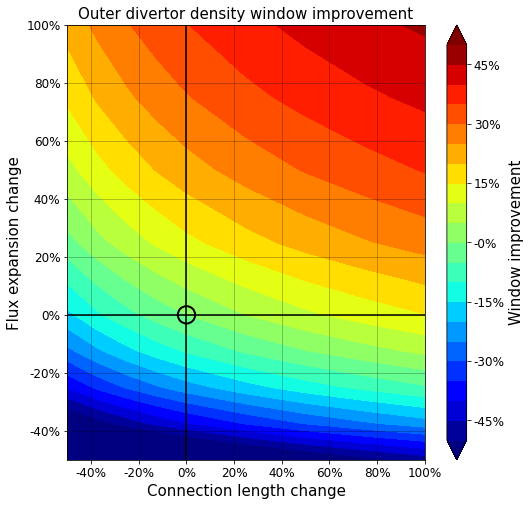

In [8]:
arr = make_arrays(scan2d_ne["ou"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

# levels = np.linspace(0, 3.0e19,22)
levels = np.arange(-0.5, 0.55, 0.05)

cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["window_norm"], levels = levels, cmap = cmap, zorder = 0, extend = "both")
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Window improvement", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor density window improvement", fontsize = 15)

# Outer and inner, power

In [42]:
scan2d_q = dict()
store = scan2d_q

list_BxBt_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])
list_Lc_scales = np.append(np.linspace(0.5, 1.0, 5), np.linspace(1.0, 2.0, 5)[1:])


for side in ["iu", "ou"]:
    store[side] = list()
    
    for i, BxBt_scale in enumerate(list_BxBt_scales):
        print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
        out = []
        results = dict()
        for param in ["window", "threshold", "window_ratio"]:
            results[param] = []

        for j, Lc_scale in enumerate(list_Lc_scales):
            print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")

            d = data[side].copy()

            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)

            constants = constants_default.copy()
            radios = radios_default.copy()
            indexRange = np.linspace(0, d["Xpoint"], 2).astype(int)
            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            constants["cz0"] = 0.02
            out.append(LRBv2(constants,radios,d["S"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                                control_variable = "power"))

            # Work on current set of results
            out[j]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]
            results["window"].append(out[j]["cvar"][-1] - out[j]["cvar"][0])
            results["window_ratio"].append(out[j]["cvar"][-1] / out[j]["cvar"][0])
            results["threshold"].append(out[j]["cvar"][0])
            results["indexRange"] = indexRange
            results["constants"] = constants
            results["radios"] = radios

            # Take out any thresholds for a window ratio < 1
            for k, x in enumerate(results["threshold"]):
                if results["window_ratio"][k] < 1:
                    results["threshold"][k] = np.nan
            try:
                results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
            except:
                pass

        results["out"] = out

        store[side].append(results)


Running BxBt scale factor: 0.50 -- Running Lc scale factor: 0.50 -- Solving...0...55...Complete in 2.4 seconds
Running Lc scale factor: 0.62 -- Solving...0...55...Complete in 2.2 seconds
Running Lc scale factor: 0.75 -- Solving...0...55...Complete in 1.8 seconds
Running Lc scale factor: 0.88 -- Solving...0...55...Complete in 2.4 seconds
Running Lc scale factor: 1.00 -- Solving...0...55...Complete in 2.1 seconds
Running Lc scale factor: 1.25 -- Solving...0...55...Complete in 1.5 seconds
Running Lc scale factor: 1.50 -- Solving...0...55...Complete in 1.9 seconds
Running Lc scale factor: 1.75 -- Solving...0...55...Complete in 1.6 seconds
Running Lc scale factor: 2.00 -- Solving...0...55...Complete in 1.9 seconds
Running BxBt scale factor: 0.62 -- Running Lc scale factor: 0.50 -- Solving...0...55...Complete in 1.6 seconds
Running Lc scale factor: 0.62 -- Solving...0...55...Complete in 2.0 seconds
Running Lc scale factor: 0.75 -- Solving...0...55...Complete in 1.9 seconds
Running Lc scale f

C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv2.py:287: RuntimeWarning: divide by zero encountered in double_scalars
  if abs(upper_error/lower_error) > 10:
C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv2.py:54: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0...55...Complete in 1.9 seconds
Running Lc scale factor: 0.62 -- Solving...******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
0...55...Complete in 2.9 seconds
Running Lc scale factor: 0.75 -- Solving...0...55...Complete in 1.7 seconds
Running Lc scale factor: 0.88 -- Solving...0...55...Complete in 1.7 seconds
Running Lc scale factor: 1.00 -- Solving...0...55...Complete in 1.7 seconds
Running Lc scale factor: 1.25 -- Solving...0...55...Complete in 2.0 seconds
Running Lc scale factor: 1.50 -- Solving...0...55...Complete in 2.0 seconds
Running Lc scale factor: 1.75 -- Solving...0...55...Complete in 1.8 seconds
Running Lc scale factor: 2.00 -- Solving...0...55...Complete in 1.5 seconds
Running BxBt scale factor: 1.00 -- Running Lc scale factor: 0.50 -- Solving...******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
0...55...Complete in 2.7 seconds
Running Lc scale factor: 0.62 -- Solving...0...55...Comple

## Inner

### Absolute

Text(0.5, 1.0, 'Inner divertor density window')

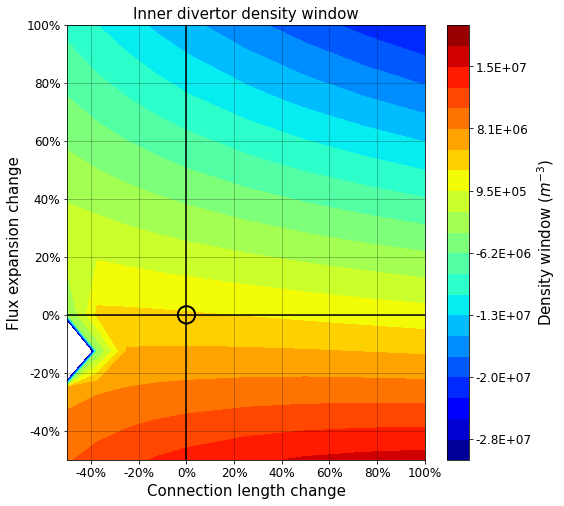

In [48]:
arr = make_arrays(scan2d_q["iu"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

levels = np.linspace(-3e7, 2e7,22)
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["window"], levels = levels, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Density window ($m^{-3}$)", size = 15)
cb.ax.set_yticklabels(["{:.1E}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Inner divertor power window", fontsize = 15)

### Relative window

Text(0.5, 1.0, 'Inner divertor power window')

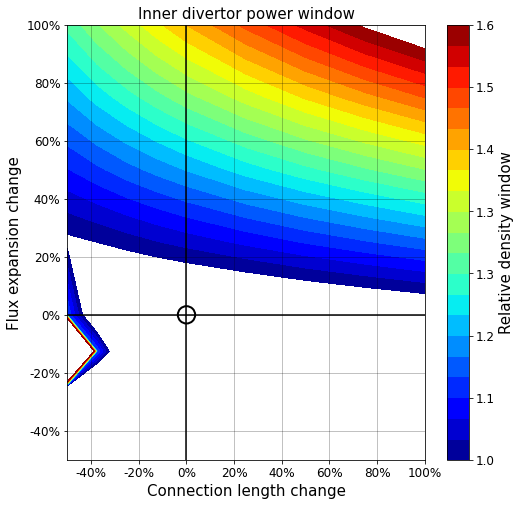

In [52]:
arr = make_arrays(scan2d_q["iu"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

levels = np.linspace(1, 1.6 ,22)
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, 1/arr["window_ratio"], levels = levels, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Relative power window", size = 15)
cb.ax.set_yticklabels(["{:.1f}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Inner divertor power window", fontsize = 15)

## Outer

### Absolute

Text(0.5, 1.0, 'Outer divertor power window')

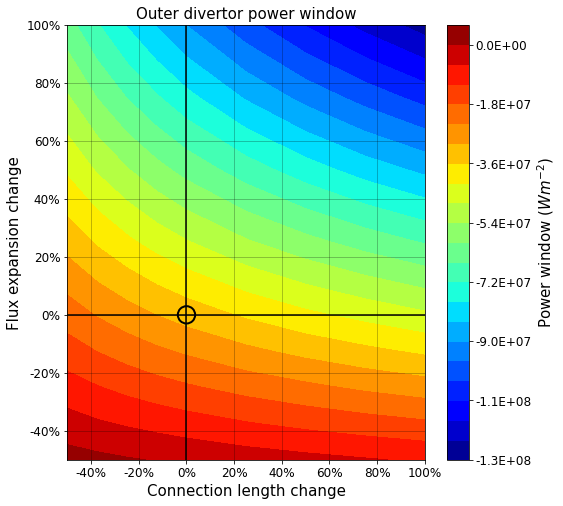

In [56]:
arr = make_arrays(scan2d_q["ou"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

levels = np.linspace(1e19, 1.3e20,22)
# levels = np.arange(-0.5, 0.55, 0.05)

cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["window"], levels = 22, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Power window ($Wm^{-2}$)", size = 15)
cb.ax.set_yticklabels(["{:.1E}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor power window", fontsize = 15)

### Relative

Text(0.5, 1.0, 'Outer divertor density window')

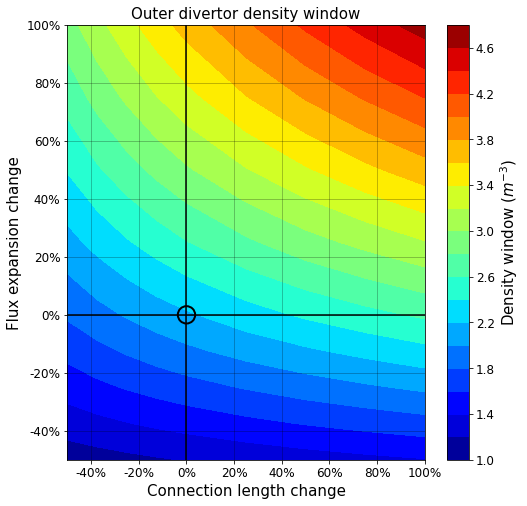

In [41]:
arr = make_arrays(scan2d_q["ou"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["window_ratio"], levels = 22, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Density window ($m^{-3}$)", size = 15)
cb.ax.set_yticklabels(["{:.1f}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor power window", fontsize = 15)

### Percent change

Text(0.5, 1.0, 'Outer divertor density window improvement')

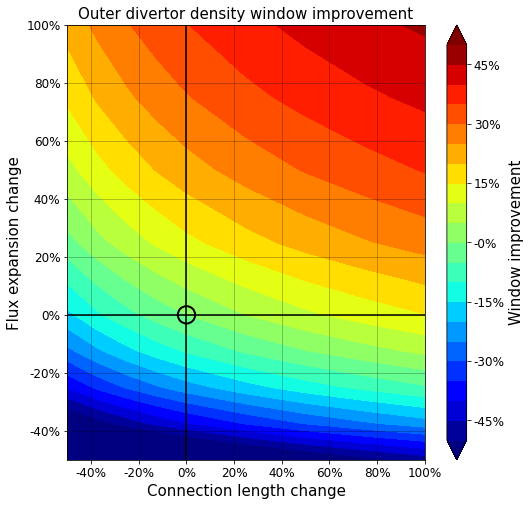

In [8]:
arr = make_arrays(scan2d_q["ou"], list_BxBt_scales, list_Lc_scales)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

# levels = np.linspace(0, 3.0e19,22)
levels = np.arange(-0.5, 0.55, 0.05)

cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["window_norm"], levels = levels, cmap = cmap, zorder = 0, extend = "both")
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.5,1.0)
ax.set_ylim(-0.5,1.0)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Window improvement", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor density power improvement", fontsize = 15)

# KallenbachAr

# Density

In [ ]:
ne_kAr = dict()

for side in ["iu"]:#, "ou"]:
    ne_kAr[side] = dict()
    print("Side {}...".format(side))
    
    for design in ["V10"]:#eqb[side].keys():
        print("Design {}...".format(design))
        
        d = eqb[side][design].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()

        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["cz0"] = 0.05
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
        
        constants["Lfunc"] = LfuncKallenbachAr        
        out = LRBv2(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                            control_variable = "density")

        out["SpolPlot"] = [d["Spol"][x] for x in indexRange]
        
        ne_kAr[side][design] = out